In [19]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import cv2
# import tifffile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc
import warnings
warnings.filterwarnings("ignore")

import random
import albumentations

import skimage


from tqdm import tqdm


def create_dir(path):
    if os.path.isdir(path)==False:
        os.makedirs(path)

In [20]:
name='siam_cc_v19B2x'

In [ ]:
from pathlib import Path
PROJ_DIRECTORY = Path.cwd()

In [21]:
# Set the training data path
data_path= str(PROJ_DIRECTORY / 'datasets' / 'pose') + "/"

In [22]:
# read the .csv files
train_labels=pd.read_csv('train_labels.csv')
rangeDF=pd.read_csv('range.csv')
train_labels.shape, rangeDF.shape

((66000, 9), (66000, 3))

In [57]:
# Read centers as predicted from yolo
sat_center_val=pd.read_csv('sat_center_val0.csv')
sat_center_train=pd.read_csv('sat_center_train0.csv')

In [23]:
NUM_TARGETS=1
CENTER_CROP=384
RESIZE=384

In [24]:
s=train_labels.loc[train_labels.chain_id=='0036465cc6',:]
s.head()

,chain_id,i,x,y,z,qw,qx,qy,qz
0,0036465cc6,0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
1,0036465cc6,1,0.571732,8.856913,-11.087827,0.996956,-0.046685,-0.046640,-0.041523
2,0036465cc6,2,-0.014641,2.789255,-5.214775,0.988523,-0.149369,-0.017915,-0.013805
3,0036465cc6,3,0.585297,-3.229511,6.535775,0.967863,-0.249140,0.025555,0.022740
4,0036465cc6,4,0.001839,-5.679097,-0.621195,0.927903,-0.371874,-0.009899,0.024641


In [25]:
# read 1 image
img=cv2.imread(data_path+'images/0036465cc6/000.png')
img.shape

(1024, 1280, 3)

In [26]:
np.mean(img,(0,1))

array([0.50849075, 0.52078781, 0.52298737])

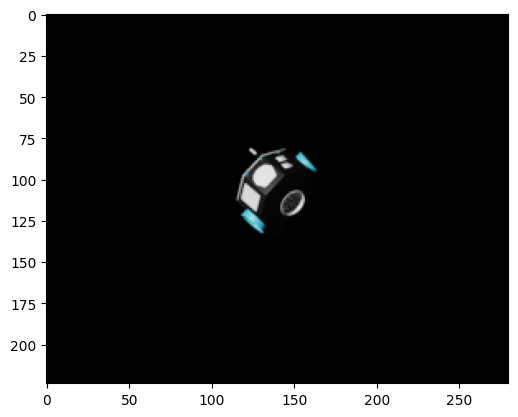

In [28]:
plt.imshow(img[400:-400,500:-500,:])
plt.show()

In [29]:
from tensorflow.keras.applications import  EfficientNetB0, EfficientNetB1, DenseNet201, ResNet50

backbone=EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=img.shape,
    pooling='avg',
)


2024-05-24 14:21:58.795661: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-24 14:21:59.285379: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-24 14:21:59.286173: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-05-24 14:21:59.286784: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1943] TensorFlow was not built with CUDA kernel binaries compatible with compute capability 6.1. CUDA kernels will be jit-compiled from PTX, which could take 30 minutes or longer.
2024-05-24 14:21:59.298152: I tensorflow/core/platform/cpu_feature_guard.cc:193] 

In [30]:
backbone=backbone.predict(np.expand_dims(img,0))
backbone.shape

2024-05-24 14:30:14.233074: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8700


1/1 [==============================] - 19s 19s/step


(1, 1280)

In [31]:
# backbone

In [24]:
#https://www.kaggle.com/martinpiotte/whale-recognition-model-with-score-0-78563
import keras
from keras import regularizers
from keras import backend as K
# from keras.preprocessing.image import img_to_array,array_to_img

from keras import regularizers
from keras.optimizers import Adam
from keras.layers import Input
from keras.layers import Activation, Add, BatchNormalization, Concatenate, Conv2D, Dense, Flatten
from keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Lambda, MaxPooling2D, Reshape, Dropout
from keras.models import Model
import tensorflow.keras.layers as L

from keras.applications.densenet import DenseNet201, preprocess_input


img_shape = img.shape#(input_size, input_size, 3)


# def build_model(img_shape=(512,512,3), freeze_backbone=False, do=0.2):
def build_model(img_shape=(512,512,3), freeze_backbone=True):

    ##############
    # BRANCH MODEL
    ##############

    backbone = EfficientNetB0(include_top=False,  weights="imagenet",  input_tensor=None,  input_shape=img_shape,  pooling=None)#     classes=1000,#     classifier_activation="softmax",#     **kwargs)

    output = GlobalAveragePooling2D()(backbone.output)
#     output = GlobalMaxPooling2D()(backbone.output)
    branch_model = Model(backbone.input,output)
    if freeze_backbone:
        for layer in branch_model.layers:
            layer.trainable = False

    del backbone

    ############
    # HEAD MODEL
    ############
#     mid        = 32
    xa_inp     = Input(shape=branch_model.output_shape[1:])
    xb_inp     = Input(shape=branch_model.output_shape[1:])

    x1         = Lambda(lambda x : x[0] - x[1])([xa_inp, xb_inp])
    x2         = Lambda(lambda x : K.square(x), output_shape=x1.shape[1:])(x1)
    x          = Concatenate()([x1, x2])
    x          = Flatten(name='flatten')(x)

    x         = Dropout(0.2)(x)
    x         = Dense(1024, activation='relu')(x)
    x         = Dropout(0.1)(x)
    x         = Dense(512, activation='relu')(x)
    # Weighted sum implemented as a Dense layer.
    out          = Dense(NUM_TARGETS, activation='linear', name='weighted-average')(x)

    head_model = Model([xa_inp, xb_inp], out, name='head')

    ########################
    # SIAMESE NEURAL NETWORK
    ########################
    # Complete model is constructed by calling the branch model on each input image,
    # and then the head model on the resulting 512-vectors.
    img_a      = Input(shape=img_shape)
    img_b      = Input(shape=img_shape)
    xa         = branch_model(img_a)
    xb         = branch_model(img_b)
    y          = head_model([xa, xb])


    model      = Model([img_a, img_b], y)

    return model, branch_model, head_model

model, branch_model, head_model = build_model(img_shape=(RESIZE,RESIZE,3), freeze_backbone=True) #64e-5
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 384, 384, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_6 (InputLayer)           [(None, 384, 384, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             (None, 1280)         4049571     ['input_5[0][0]',                
                                                                  'input_6[0][0]']          

In [ ]:
# def build_model(img_shape=(512,512,3), freeze_backbone=True):

#     ##############
#     # BRANCH MODEL
#     ##############
#     backbone = EfficientNetB0(include_top=False,  weights="imagenet",  input_tensor=None,  input_shape=img_shape,  pooling=None)#     classes=1000,#     classifier_activation="softmax",#     **kwargs)

#     output = GlobalAveragePooling2D()(backbone.output)
#     branch_model = Model(backbone.input,output)
#     if freeze_backbone:
#         for layer in branch_model.layers:
#             layer.trainable = False
#     del backbone

#     ############
#     # HEAD MODEL
#     ############
#     xa_inp     = Input(shape=branch_model.output_shape[1:])
#     xb_inp     = Input(shape=branch_model.output_shape[1:])

#     x1         = Lambda(lambda x : x[0] - x[1])([xa_inp, xb_inp])
#     x2         = Lambda(lambda x : K.square(x), output_shape=x1.shape[1:])(x1)
#     x          = Concatenate()([x1, x2])
#     x          = Flatten(name='flatten')(x)

#     x         = Dropout(0.2)(x)
#     x         = Dense(1024, activation='relu')(x)
#     x         = Dropout(0.1)(x)
#     x         = Dense(512, activation='relu')(x)
#     out          = Dense(NUM_TARGETS, activation='linear', name='weighted-average')(x)

#     head_model = Model([xa_inp, xb_inp], out, name='head')

#     ########################
#     # SIAMESE NEURAL NETWORK
#     ########################
#     img_a      = Input(shape=img_shape)
#     img_b      = Input(shape=img_shape)
#     xa         = branch_model(img_a)
#     xb         = branch_model(img_b)
#     y          = head_model([xa, xb])

#     model      = Model([img_a, img_b], y)

#     return model, branch_model, head_model

In [37]:
cases = os.listdir(data_path+'images')
len(cases)

621

In [38]:
# np.unique([len(os.listdir(data_path+'images/'+x)) for x in cases],return_counts=True)

In [39]:
# np.where(np.array([len(os.listdir(data_path+'images/'+x)) for x in cases])==83)

In [40]:
# cases[492]

In [41]:
# len(os.listdir(data_path+'images/'+cases[492]))

In [42]:
# os.listdir(data_path+'images/'+cases[0])[:5]

In [ ]:
# train-val split 80-20
np.random.seed(42)
val_cases=np.random.choice(cases,int(0.2*(len(cases))), replace=False)
train_cases=np.array([x for x in cases if x not in val_cases])
len(val_cases),len(np.unique(val_cases)),len(train_cases)

(124, 124, 497)

In [44]:
# [x for x in train_cases if x in [cases[492]]]

In [45]:
val_ids=[]
val_targets=[]
for c in tqdm(val_cases):
    p=data_path+'images/'+c+'/'
    if os.path.isdir(p):
        all_images=os.listdir(p)
        all_images=[x for x in all_images if x not in ['000.png']]
        for im in all_images:
            val_ids.append([p+'000.png', p+im])
            val_targets.append(train_labels.loc[(train_labels.chain_id==c)&(train_labels.i==int(im.split('.')[0])),
                                                                        ['x','y','z','qw','qx','qy','qz'] ].values)

val_ids=np.vstack(val_ids)
val_targets=np.vstack(val_targets)
len(val_ids),val_targets.shape

100%|██████████| 124/124 [01:41<00:00,  1.22it/s]


(12276, (12276, 7))

In [46]:
val_chains=[x[1].split('/')[-2] for x in val_ids]
val_chains_i=[int(x[1].split('/')[-1][:-4]) for x in val_ids]
ref=pd.DataFrame({'chain_id': np.unique(val_chains)})
ref['i']=0
ref['x']=0
ref['y']=0
ref['z']=0
ref['qw']=1
ref['qx']=0
ref['qy']=0
ref['qz']=0
# train_labels

# val_chain_gt_df = pd.DataFrame(np.concatenate((np.expand_dims(val_chains,-1), np.expand_dims(val_chains_i,-1), val_targets),-1))
# val_chain_gt_df.columns=train_labels.columns
# val_chain_gt_df.iloc[:,1:]=val_chain_gt_df.iloc[:,1:].astype(float)
# val_chain_gt_df = pd.concat([val_chain_gt_df, ref]).sort_values(['chain_id','i']).reset_index(drop=True)
# val_chain_gt_df.to_csv('val_chain_gt_df.csv',index=False)
# val_chain_gt_df
# # train_labels

In [ ]:
train_ids=[]
train_targets=[]
for c in tqdm(train_cases):
    p=data_path+'images/'+c+'/'
    if os.path.isdir(p):
        all_images=os.listdir(p)
        all_images=[x for x in all_images if x not in ['000.png']]
        for im in all_images:
            train_ids.append([p+'000.png', p+im])
            train_targets.append(train_labels.loc[(train_labels.chain_id==c)&(train_labels.i==int(im.split('.')[0])),
                                                                        ['x','y','z','qw','qx','qy','qz'] ].values)

train_ids=np.vstack(train_ids)
train_targets=np.vstack(train_targets)
len(train_ids),train_targets.shape


100%|██████████| 497/497 [06:38<00:00,  1.25it/s]


(49186, (49186, 7))

In [37]:
# train_shapes=[]
# failed_reading=[]
# for c in tqdm(train_cases):
#     p=data_path+'images/'+c+'/'
#     all_images=os.listdir(p)
# #     all_images=[x for x in all_images if x not in ['000.png']]
#     for im in all_images:
#         try:
#             img = cv2.imread(p+im)
#             train_shapes.append( [p+im, img.shape])
#         except:
#             failed_reading.append( p+im)

# # np.unique(np.vstack(train_shapes)[:,1])
# # array([(1024, 1280, 3)], dtype=object)
# # failed_reading
# # [data_path + 'images/c7b8e6149d/005.png']

In [38]:
# val_shapes=[]
# val_failed_reading=[]
# for c in tqdm(val_cases):
#     p=data_path+'images/'+c+'/'
#     all_images=os.listdir(p)
# #     all_images=[x for x in all_images if x not in ['000.png']]
#     for im in all_images:
#         try:
#             img = cv2.imread(p+im)
#             val_shapes.append( [p+im, img.shape])
#         except:
#             val_failed_reading.append( p+im)
# # (array([(1024, 1280, 3)], dtype=object),
# #  ['/fast/Spacecraft_Pose_Estimation/images/898466710c/059.png',
# #   '/fast/Spacecraft_Pose_Estimation/images/575ebc7410/040.png',
# #   '/fast/Spacecraft_Pose_Estimation/images/af0973ade8/059.png'])
# # for n in val_failed_reading:
# #     print(np.where(val_ids[:,1]==n)[0][0])
# # 856
# # 1285
# # 1747


In [39]:
# for n in val_failed_reading:
#     print(np.where(val_ids[:,1]==n)[0][0])

In [ ]:
# Remove corrupted images

In [48]:
removethisids=np.array([[data_path + 'images/c7b8e6149d/000.png', data_path + 'images/c7b8e6149d/005.png'],

        [data_path + 'images/898466710c/000.png', data_path + 'images/898466710c/059.png'],
        [data_path + 'images/575ebc7410/000.png', data_path + 'images/575ebc7410/040.png'],
        [data_path + 'images/af0973ade8/000.png', data_path + 'images/af0973ade8/059.png']])
removethisids.shape

remove_inds_from_train = []
for i in range(len(removethisids)):
    try:
        remove_inds_from_train.append(np.where(train_ids[:,1]==removethisids[i][1])[0][0])
    except:
        pass
remove_inds_from_val = []
for i in range(len(removethisids)):
    try:
        remove_inds_from_val.append(np.where(val_ids[:,1]==removethisids[i][1])[0][0])
    except:
        pass
remove_inds_from_train, remove_inds_from_val

if len(remove_inds_from_train)>0:
    train_ids=train_ids[[x for x in range(len(train_ids)) if x not in remove_inds_from_train],:]
    train_targets=train_targets[[x for x in range(len(train_targets)) if x not in remove_inds_from_train],:]

if len(remove_inds_from_val)>0:
    val_ids=val_ids[[x for x in range(len(val_ids)) if x not in remove_inds_from_val],:]
    val_targets=val_targets[[x for x in range(len(val_targets)) if x not in remove_inds_from_val],:]


train_ids.shape, train_targets.shape, val_ids.shape, val_targets.shape

if len(remove_inds_from_val)>0:
    val_chains=np.array(val_chains)[[x for x in range(len(val_chains)) if x not in remove_inds_from_val]]
    val_chains_i=np.array(val_chains_i)[[x for x in range(len(val_chains_i)) if x not in remove_inds_from_val]]
len(val_chains_i),len(val_chains)

(12273, 12273)

In [32]:
# train_ids=train_ids[[x for x in range(len(train_ids)) if x not in [39186]],:]
# train_targets=train_targets[[x for x in range(len(train_targets)) if x not in [39186]],:]

# val_ids=val_ids[[x for x in range(len(val_ids)) if x not in [856, 1285, 1747]],:]
# val_targets=val_targets[[x for x in range(len(val_targets)) if x not in [856, 1285, 1747]],:]


# train_ids.shape, train_targets.shape, val_ids.shape, val_targets.shape

In [33]:
# val_chains=np.array(val_chains)[[x for x in range(len(val_chains)) if x not in [856, 1285, 1747]]]
# val_chains_i=np.array(val_chains_i)[[x for x in range(len(val_chains_i)) if x not in [856, 1285, 1747]]]
# len(val_chains_i),len(val_chains)

In [49]:
val_chain_gt_df = pd.DataFrame(np.concatenate((np.expand_dims(val_chains,-1), np.expand_dims(val_chains_i,-1), val_targets),-1))
val_chain_gt_df.columns=train_labels.columns
val_chain_gt_df.iloc[:,1:]=val_chain_gt_df.iloc[:,1:].astype(float)
val_chain_gt_df = pd.concat([val_chain_gt_df, ref]).sort_values(['chain_id','i']).reset_index(drop=True)
val_chain_gt_df.to_csv('val_chain_gt_df.csv',index=False)
val_chain_gt_df
# train_labels

,chain_id,i,x,y,z,qw,qx,qy,qz
0,031dbad3c0,0,0,0,0,1,0,0,0
1,031dbad3c0,1.0,12.114075,-78.491692,-11.749588,0.990646,0.040924,-0.013321,0.129492
2,031dbad3c0,2.0,7.685059,-65.040146,-11.8153,0.993682,0.037831,-0.012172,0.104963
3,031dbad3c0,3.0,17.884277,-97.27285,-10.788047,0.985571,0.048023,-0.016243,0.161491
4,031dbad3c0,4.0,6.934784,-54.452129,-8.48818,0.991626,0.094688,-0.003965,0.087727
...,...,...,...,...,...,...,...,...,...
12392,fe8bbecd83,95.0,35.061722,9.433044,-131.909546,0.966501,0.024006,-0.254768,-0.019803
12393,fe8bbecd83,96.0,45.657578,25.128151,-145.975113,0.955316,0.052766,-0.287164,-0.046076
12394,fe8bbecd83,97.0,40.431274,-11.17926,-141.36113,0.952461,0.140735,-0.265455,0.050442
12395,fe8bbecd83,98.0,42.742828,-7.558107,-143.729889,0.949211,0.152283,-0.271309,0.046901


In [50]:
# from keras.preprocessing import img_to_array,array_to_img

In [51]:
# train_ids

In [52]:
def center_crop(img, final_size=CENTER_CROP):
    y, x = img.shape[:2]
    y2 = max(0, int(y/2-final_size/2))
    x2 = max(0, int(x/2-final_size/2))
#     print(y2,x2)
    return img[y2:-y2,x2:-x2,:]
img.shape, center_crop(img).shape

((1024, 1280, 3), (384, 384, 3))

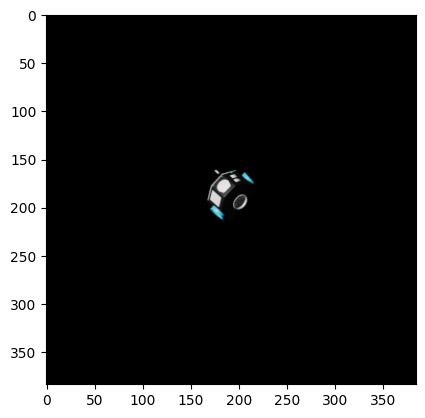

In [53]:
plt.imshow(center_crop(img))
plt.show()

In [54]:
def np_log_with_sign(ar):
    signs = np.sign(ar)
    return np.log(np.abs(ar))*signs

In [58]:
sat_center=pd.concat([sat_center_train,sat_center_val]).reset_index(drop=True)
sat_center.shape

(60604, 3)

In [59]:
# sat_center.path.unique().shape

In [60]:
sat_center_paths=sat_center.path.values

In [62]:
# for sp in sat_center_paths:
#     x,y=sat_center.loc[sat_center.path==sp,['centerW','centerH']].values[0]
# #     print(sp, x, y)

In [63]:
# sat_center.loc[sat_center.path=='/fast/Spacecraft_Pose_Estimation/images/024e86dc87/000.png',['centerW','centerH']].values.shape

In [64]:
def sat_center_crop(img, center=(512, 640), SIZE=384):
    y, x = img.shape[:2]
    halfS=int(SIZE/2)
    y1 = min(y-384, max(0, center[0]-halfS))
    y2 = min(y, max(384, center[0]+halfS))
    x1 = min(x-384, max(0, center[1]-halfS))
    x2 = min(x, max(384, center[1]+halfS))
#     print(y2,x2)
#     print(y1,y2,x1,x2)
    return img[y1:y2,x1:x2,:]

In [65]:
# data_path+'images/0036465cc6/000.png'
# t=sat_center.loc[sat_center.path=='/fast/Spacecraft_Pose_Estimation/images/0036465cc6/000.png',['centerW','centerH']].values
# if t.shape[0]==1:
#     centerW, centerH = t[0]
# else:
#     centerW, centerH = 640, 512
# plt.imshow(sat_center_crop(img, (centerH, centerW)))
# plt.show()
# centerW, centerH

In [66]:
# shapes=[]
# for tid in tqdm(train_ids):
#     img1 = cv2.imread(tid[1])
#     if tid[1] in sat_center_paths:
#         t=sat_center.loc[sat_center.path==tid[1],['centerW','centerH']].values
#         if t.shape[0]==1:
#             centerW, centerH = t[0]
#         else:
#             centerW, centerH = 640, 512
#         #                     print(centerW, centerH)
#         img1 = sat_center_crop(img1, center=( centerH, centerW))
#         s=img1.shape
#         shapes.append(s)
# #         print(s)
#         if s != (384,384,3):
#             break

In [67]:
# img1 = cv2.imread(tid[1])
# if tid[1] in sat_center_paths:
#     t=sat_center.loc[sat_center.path==tid[1],['centerW','centerH']].values
#     if t.shape[0]==1:
#         centerW, centerH = t[0]
#     else:
#         centerW, centerH = 640, 512
#     #                     print(centerW, centerH)
#     img1 = sat_center_crop(img1, center=( centerH, centerW))
#     s=img1.shape
# s

In [68]:
# img1 = cv2.imread(tid[1])
# plt.imshow(sat_center_crop(img1, (centerH, centerW)))
# plt.show()

# centerH, centerW, img1.shape, s


In [69]:
# img1.shape

In [70]:
def data_generator_siam(ids, labels):
#     replacement=True #no other way possible
    #best ratio one of 1,2,3,
#     IMAGE0 = zerolabelnum
#     batch_size_multiplier = int(16/(zerolabelnum+1))
    while True:
        for start in range(0, len(ids), batch_size):
            x1_batch = []
            x2_batch = []
            y_batch = []
            end = min(start + batch_size, len(ids))
            ids_batch_ = ids[start:end]
            y_batch = labels[start:end,:].copy()

            y_batch = y_batch[:,0]


            for id_i in ids_batch_:

                img1 = cv2.imread(id_i[0])
                if id_i[0] in sat_center_paths:
                    t=sat_center.loc[sat_center.path==id_i[0],['centerW','centerH']].values
                    if t.shape[0]==1:
                        centerW, centerH = t[0]
                    else:
                        centerW, centerH = 640, 512
                    img1 = sat_center_crop(img1, center=( centerH, centerW))
                else:
                    img1 = center_crop(img1)
                img2 = cv2.imread(id_i[1])
                if id_i[1] in sat_center_paths:
                    t=sat_center.loc[sat_center.path==id_i[1],['centerW','centerH']].values
                    if t.shape[0]==1:
                        centerW, centerH = t[0]
                    else:
                        centerW, centerH = 640, 512

                    img2 = sat_center_crop(img2, center=( centerH, centerW))
                else:
                    img2 = center_crop(img2)
                x1_batch.append(img1)
                x2_batch.append(img2)

            x1_batch = np.array(x1_batch, np.float32) #/ 255
            x2_batch = np.array(x2_batch, np.float32) #/ 255

            yield [x1_batch.astype('uint8'), x2_batch.astype('uint8')], y_batch


In [71]:
epochs = 20
snapshots = 1
lr_0 = 0.0001
def cosine_anneal_schedule(t):
    cos_inner = np.pi * (t % (epochs // snapshots))
    cos_inner /= epochs // snapshots
    cos_out = np.cos(cos_inner) + 1
    return float(lr_0 / 2 * cos_out)
cosine_anneal_schedule_list=[cosine_anneal_schedule(x) for x in range(epochs)]

# np.array(cosine_anneal_schedule_list)

In [72]:
def lrfn(epoch):
    return cosine_anneal_schedule_list[epoch]
def np_exp_with_sign(ar):
    signs = np.sign(ar)
    return np.exp(np.abs(ar))*signs

In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
import tensorflow as tf
import subprocess

weightsname=name+'.hdf5'
text_name = 'logs/'+name+'.txt'


batch_size = 4
for cycle in range(epochs):

    model.compile(Adam(lr=cosine_anneal_schedule_list[cycle]), loss='mean_absolute_percentage_error')

    h = model.fit_generator(data_generator_siam(train_ids, train_targets),
                            steps_per_epoch = np.ceil(len(train_ids)/batch_size),
                            epochs=1,
                            verbose=1)
    val_preds=model.predict( data_generator_siam(val_ids, val_targets),
                        steps=np.ceil(len(val_ids)/batch_size),
                       batch_size=batch_size)
    val_predsD=np.concatenate((val_preds,np.zeros((len(val_preds),6))),1)

    val_predsD[:,0] = np.clip(val_predsD[:,0], 0, 100)
    val_predsD[:,1:3] = np.clip(val_predsD[:,1:3], 0, 0)

    val_predsD[:,3:] = [1,0,0,0]

    val_chain_preds_df = pd.DataFrame(np.concatenate((np.expand_dims(val_chains,-1), np.expand_dims(val_chains_i,-1), val_predsD),-1))
    val_chain_preds_df.columns=train_labels.columns#[1:]
    val_chain_preds_df.iloc[:,1:]=val_chain_preds_df.iloc[:,1:].astype(float)
    val_chain_preds_df = pd.concat([val_chain_preds_df, ref]).sort_values(['chain_id','i']).reset_index(drop=True)

    val_chain_preds_df.to_csv('val_chain_preds_'+name+'.csv',index=False)

    result = subprocess.run(['python','score.py', 'val_chain_preds_'+name+'.csv', 'val_chain_gt_df.csv'],
                            stdout=subprocess.PIPE)
    with open(text_name, "a") as text_file:
        text_file.write(result.stdout.decode('utf-8'))

    model.save_weights('weights/ep'+str(cycle)+weightsname)


with open(text_name, "a") as text_file:
    text_file.write('\n')


In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
import tensorflow as tf
import subprocess

weightsname=name+'.hdf5'
text_name = 'logs/'+name+'.txt'

batch_size = 4
for cycle in range(20,20+epochs):

    model.compile(Adam(lr=cosine_anneal_schedule_list[cycle-20]), loss='mean_absolute_percentage_error')

    h = model.fit_generator(data_generator_siam(train_ids, train_targets),
                            steps_per_epoch = np.ceil(len(train_ids)/batch_size),
                            epochs=1,
                            verbose=1)
    val_preds=model.predict( data_generator_siam(val_ids, val_targets),
                        steps=np.ceil(len(val_ids)/batch_size),
                       batch_size=batch_size)
    val_predsD=np.concatenate((val_preds,np.zeros((len(val_preds),6))),1)

    val_predsD[:,0] = np.clip(val_predsD[:,0], 0, 400)
    val_predsD[:,1:3] = np.clip(val_predsD[:,1:3], 0, 0)

    val_predsD[:,3:] = [1,0,0,0]

    val_chain_preds_df = pd.DataFrame(np.concatenate((np.expand_dims(val_chains,-1), np.expand_dims(val_chains_i,-1), val_predsD),-1))
    val_chain_preds_df.columns=train_labels.columns#[1:]
    val_chain_preds_df.iloc[:,1:]=val_chain_preds_df.iloc[:,1:].astype(float)
    val_chain_preds_df = pd.concat([val_chain_preds_df, ref]).sort_values(['chain_id','i']).reset_index(drop=True)

    val_chain_preds_df.to_csv('val_chain_preds_'+name+'.csv',index=False)

    result = subprocess.run(['python','score.py', 'val_chain_preds_'+name+'.csv', 'val_chain_gt_df.csv'],
                            stdout=subprocess.PIPE)
    with open(text_name, "a") as text_file:
        text_file.write(result.stdout.decode('utf-8'))

    model.save_weights('weights/ep'+str(cycle)+weightsname)


with open(text_name, "a") as text_file:
    text_file.write('\n')


In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
import tensorflow as tf
import subprocess

weightsname=name+'b.hdf5'
text_name = 'logs/'+name+'.txt'

batch_size = 4
for cycle in range(40,40+epochs):

    model.compile(Adam(lr=cosine_anneal_schedule_list[cycle-40]), loss='mean_absolute_percentage_error')

    h = model.fit_generator(data_generator_siam(train_ids, train_targets),
                            steps_per_epoch = np.ceil(len(train_ids)/batch_size),
                            epochs=1,
                            verbose=1)
    val_preds=model.predict( data_generator_siam(val_ids, val_targets),
                        steps=np.ceil(len(val_ids)/batch_size),
                       batch_size=batch_size)
    val_predsD=np.concatenate((val_preds,np.zeros((len(val_preds),6))),1)

    val_predsD[:,0] = np.clip(val_predsD[:,0], 0, 100)
    val_predsD[:,1:3] = np.clip(val_predsD[:,1:3], 0, 0)

    val_predsD[:,3:] = [1,0,0,0]

    val_chain_preds_df = pd.DataFrame(np.concatenate((np.expand_dims(val_chains,-1), np.expand_dims(val_chains_i,-1), val_predsD),-1))
    val_chain_preds_df.columns=train_labels.columns#[1:]
    val_chain_preds_df.iloc[:,1:]=val_chain_preds_df.iloc[:,1:].astype(float)
    val_chain_preds_df = pd.concat([val_chain_preds_df, ref]).sort_values(['chain_id','i']).reset_index(drop=True)

    val_chain_preds_df.to_csv('val_chain_preds_'+name+'.csv',index=False)

    result = subprocess.run(['python','score.py', 'val_chain_preds_'+name+'.csv', 'val_chain_gt_df.csv'],
                            stdout=subprocess.PIPE)
    with open(text_name, "a") as text_file:
        text_file.write(result.stdout.decode('utf-8'))

    model.save_weights('weights/ep'+str(cycle)+weightsname)


with open(text_name, "a") as text_file:
    text_file.write('\n')


In [ ]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
import tensorflow as tf
import subprocess

weightsname=name+'b.hdf5'
text_name = 'logs/'+name+'.txt'

batch_size = 4
for cycle in range(60,60+epochs):

    model.compile(Adam(lr=cosine_anneal_schedule_list[cycle-60]), loss='mean_absolute_percentage_error')

    h = model.fit_generator(data_generator_siam(train_ids, train_targets),
                            steps_per_epoch = np.ceil(len(train_ids)/batch_size),
                            epochs=1,
                            verbose=1)
    val_preds=model.predict( data_generator_siam(val_ids, val_targets),
                        steps=np.ceil(len(val_ids)/batch_size),
                       batch_size=batch_size)
    val_predsD=np.concatenate((val_preds,np.zeros((len(val_preds),6))),1)

    val_predsD[:,0] = np.clip(val_predsD[:,0], 0, 100)
    val_predsD[:,1:3] = np.clip(val_predsD[:,1:3], 0, 0)

    val_predsD[:,3:] = [1,0,0,0]

    val_chain_preds_df = pd.DataFrame(np.concatenate((np.expand_dims(val_chains,-1), np.expand_dims(val_chains_i,-1), val_predsD),-1))
    val_chain_preds_df.columns=train_labels.columns#[1:]
    val_chain_preds_df.iloc[:,1:]=val_chain_preds_df.iloc[:,1:].astype(float)
    val_chain_preds_df = pd.concat([val_chain_preds_df, ref]).sort_values(['chain_id','i']).reset_index(drop=True)

    val_chain_preds_df.to_csv('val_chain_preds_'+name+'.csv',index=False)

    result = subprocess.run(['python','score.py', 'val_chain_preds_'+name+'.csv', 'val_chain_gt_df.csv'],
                            stdout=subprocess.PIPE)
    with open(text_name, "a") as text_file:
        text_file.write(result.stdout.decode('utf-8'))

    model.save_weights('weights/ep'+str(cycle)+weightsname)


with open(text_name, "a") as text_file:
    text_file.write('\n')


In [100]:
val_predsD=np.concatenate((val_preds,np.zeros((len(val_preds),6))),1)

val_predsD[:,0] = np.clip(val_predsD[:,0], 0, 400)**1.0
val_predsD[:,1:3] = np.clip(val_predsD[:,1:3], 0, 0)

val_predsD[:,3:] = [1,0,0,0]

val_chain_preds_df = pd.DataFrame(np.concatenate((np.expand_dims(val_chains,-1), np.expand_dims(val_chains_i,-1), val_predsD),-1))
val_chain_preds_df.columns=train_labels.columns#[1:]
val_chain_preds_df.iloc[:,1:]=val_chain_preds_df.iloc[:,1:].astype(float)
val_chain_preds_df = pd.concat([val_chain_preds_df, ref]).sort_values(['chain_id','i']).reset_index(drop=True)

val_chain_preds_df.to_csv('val_chain_preds_'+name+'.csv',index=False)

result = subprocess.run(['python','score.py', 'val_chain_preds_'+name+'.csv', 'val_chain_gt_df.csv'],
                        stdout=subprocess.PIPE)
result

CompletedProcess(args=['python', 'score.py', 'val_chain_preds_siam_cc_v19B2x_again.csv', 'val_chain_gt_df.csv'], returncode=0, stdout=b'{\n  "mean_translation_error": 0.8944934970510117,\n  "mean_rotation_error": 0.9999999999999992,\n  "score": 1.8944934970510108\n}\n')

In [88]:
val_predsD=np.concatenate((val_preds,np.zeros((len(val_preds),6))),1)

val_predsD[:,0] = np.clip(val_predsD[:,0], 0, 400)**1.02
val_predsD[:,1:3] = np.clip(val_predsD[:,1:3], 0, 0)

val_predsD[:,3:] = [1,0,0,0]

val_chain_preds_df = pd.DataFrame(np.concatenate((np.expand_dims(val_chains,-1), np.expand_dims(val_chains_i,-1), val_predsD),-1))
val_chain_preds_df.columns=train_labels.columns#[1:]
val_chain_preds_df.iloc[:,1:]=val_chain_preds_df.iloc[:,1:].astype(float)
val_chain_preds_df = pd.concat([val_chain_preds_df, ref]).sort_values(['chain_id','i']).reset_index(drop=True)

val_chain_preds_df.to_csv('val_chain_preds_'+name+'.csv',index=False)

result = subprocess.run(['python','score.py', 'val_chain_preds_'+name+'.csv', 'val_chain_gt_df.csv'],
                        stdout=subprocess.PIPE)
result

CompletedProcess(args=['python', 'score.py', 'val_chain_preds_siam_cc_v19B2x_again.csv', 'val_chain_gt_df.csv'], returncode=0, stdout=b'{\n  "mean_translation_error": 0.894186669224705,\n  "mean_rotation_error": 0.9999999999999992,\n  "score": 1.8941866692247042\n}\n')